In [61]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [62]:
def SIFT_Matches(image1, image2, MAX_FEATURES=3000):
    # Convertimos las imágenes de color a escala de grises
    new_image_1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    new_image_2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Creamos un detector SIFT con un límite máximo de características
    sift = cv2.SIFT_create(MAX_FEATURES)

    # Detectamos y calculamos descriptores para las características en ambas imágenes
    Key_Points_1, des1 = sift.detectAndCompute(new_image_1, None)
    Key_Points_2, des2 = sift.detectAndCompute(new_image_2, None)

    # Utilizamos el matcher de fuerza bruta (Brute-Force) para hacer coincidir los descriptores
    Bjf = cv2.BFMatcher()
    matches = Bjf.knnMatch(des1, des2, k=2)

    # Filtramos las coincidencias para mantener solo las que son lo suficientemente buenas
    Correct_Matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            Correct_Matches.append([m])

    # Extraemos las coordenadas de las características coincidentes en ambas imágenes
    left_coords = np.float32([Key_Points_1[m[0].queryIdx].pt for m in Correct_Matches])
    right_coords = np.float32([Key_Points_2[m[0].trainIdx].pt for m in Correct_Matches])

    return left_coords, right_coords

In [63]:
image1 = cv2.imread("pic_a.jpg")
image2 = cv2.imread("pic_b.jpg")

# Llamar a la función SIFT_Matches
left_coords, right_coords = SIFT_Matches(image1, image2)

# Dibujar puntos en las imágenes
image1_points = image1.copy()
image2_points = image2.copy()

for coord in left_coords:
    x, y = coord
    cv2.circle(image1_points, (int(x), int(y)), 5, (0, 255, 0), -1)  # Dibuja un círculo verde en la imagen1

for coord in right_coords:
    x, y = coord
    cv2.circle(image2_points, (int(x), int(y)), 5, (0, 255, 0), -1) 

# Mostrar las imágenes con los puntos dibujados
cv2.imshow("Image 1 with Points", image1_points)
cv2.imshow("Image 2 with Points", image2_points)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [64]:
def FUNDAMENTAL_MATRIX_ESTIMATION(LEFT_IMG_PTS, RIGHT_IMG_PTS):

    A = [] 

    for i in range(8): #Iter over 7 random points
        ul,vl = LEFT_IMG_PTS[i]
        ur,vr = RIGHT_IMG_PTS[i]

        row = np.asarray([ul * ur, ul * vr, ul, vl * ur, vr * vl, vl, ur, vr, 1])

        A.append(row)

    

    A = np.asarray(A)

    U,S,V = np.linalg.svd(A)
    F = np.reshape(V[-1,:],(3,3))

    UF , SF , VF = np.linalg.svd(F)
    SF = np.diag(SF)
    SF[2,2] = 0

    F = UF @ (SF @ VF)

    return F

In [65]:
F = FUNDAMENTAL_MATRIX_ESTIMATION(left_coords,right_coords)
print(F)

print(left_coords)

[[ 5.58083214e-05  5.88150541e-05 -1.65022188e-02]
 [-6.64747270e-05  9.99325318e-06 -1.35300001e-03]
 [ 1.12318599e-02 -4.62685706e-03  9.99789114e-01]]
[[   5.8011637  424.79526  ]
 [  28.88979    188.03989  ]
 [  30.748396   337.4057   ]
 [  35.41707    211.87898  ]
 [  41.736008   198.68463  ]
 [  51.927483   213.5461   ]
 [  55.05654    391.51294  ]
 [  55.719234   215.35275  ]
 [  56.0922     353.02353  ]
 [  58.929474   391.61642  ]
 [  63.668297   341.82608  ]
 [  72.368965   394.6816   ]
 [  80.633484   394.60916  ]
 [  81.72821    374.23608  ]
 [  83.47105      9.044988 ]
 [  84.31124    379.20367  ]
 [  85.45239    384.414    ]
 [  85.83764    392.5846   ]
 [  87.41187    224.6792   ]
 [  88.52578    379.59924  ]
 [  89.43177    375.2835   ]
 [  89.43177    375.2835   ]
 [ 137.92741    401.66458  ]
 [ 157.77216    327.77463  ]
 [ 173.49266    281.12704  ]
 [ 173.96371    310.94913  ]
 [ 221.03133    330.21518  ]
 [ 222.71147    415.19003  ]
 [ 222.71147    415.19003  ]
 [ 22

In [66]:

#CENTERING DE DATA CORRESPONDENCE POINTS
ul_mean = np.mean (left_coords[ : , 0])
vl_mean = np.mean (left_coords[ : , 1])

ur_mean = np.mean (right_coords[ : , 0])
vr_mean = np.mean (right_coords[ : , 1])

In [67]:
#NEW CENTERING POINTS

print(left_coords.shape == right_coords.shape)

N = len(left_coords)

center_left_coords = np.zeros((N,2))
center_right_coords = np.zeros((N,2))

center_left_coords[: , 0] = left_coords[ : , 0] - ul_mean
center_left_coords[: , 1] = left_coords[ : , 1] - vl_mean

center_right_coords[: , 0] = right_coords[ : , 0] - ur_mean
center_right_coords[: , 1] = right_coords[ : , 1] - vr_mean


s_left = np.sqrt(2) / (1/N * np.sum(center_left_coords[:,0]**2) + np.sum(center_left_coords[:,1]**2)  )**(0.5)
s_right = np.sqrt(2) / (1/N * np.sum(center_right_coords[:,0]**2) + np.sum(center_right_coords[:,1]**2) )**(0.5)

print(s_left,s_right)

a1 = np.identity(3)
a1[0,0],a1[1,1] = s_left,s_left
a2 = np.identity(3)
a2[0,2],a2[1,2] = -ul_mean,-vl_mean
Ta = a1 @ a2

b1 = np.identity(3)
b1[0,0],b1[1,1] = s_right,s_right
b2 = np.identity(3)
b2[0,2],b2[1,2] = -ur_mean,-vr_mean
Tb =  b1 @ b2


F_norm = np.linalg.inv(Tb.T) @ (F @ np.linalg.inv(Ta))

True
0.0005590613931265227 0.00054352018404392


In [68]:
def RANSAC(left_coords, right_coords, iteraciones, tol):
    n = len(left_coords)  # Número de puntos
    Max_Inlier = 0  # Inicializamos el contador para el máximo número de inliers

    for i in range(iteraciones):
        Inlier = 0  # Inicializamos el contador de inliers para esta iteración

        # Seleccionamos aleatoriamente 8 pares de puntos
        Idx_random = np.random.choice(n, size=8, replace=False)
        left_coords_random = left_coords[Idx_random, :]
        right_coords_random = right_coords[Idx_random, :]
        

        # Estimamos la matriz fundamental F con estos 8 pares de puntos
        F = FUNDAMENTAL_MATRIX_ESTIMATION(left_coords_random, right_coords_random)

        for j in range(n):
            # Obtenemos un par de puntos
            Lpts, Rpts = left_coords[j], right_coords[j]

            # Convertimos los puntos en vectores homogéneos (añadiendo 1)
            Lpts, Rpts = np.append(Lpts, 1).reshape((3, 1)), np.append(Rpts, 1).reshape((3, 1))

            # Calculamos la distancia epipolar (residual)
            res = (Lpts.T @ F) @ Rpts

            # Comparamos la distancia epipolar con el umbral de tolerancia
            if abs(res) <= tol:
                Inlier += 1  # Si está dentro de la tolerancia, lo consideramos un inlier

        if Inlier > Max_Inlier:
            Max_Inlier = Inlier  # Actualizamos el número máximo de inliers
            Final_F = F  # Actualizamos la mejor matriz fundamental encontrada hasta ahora

    return Final_F  # Devolvemos la matriz fundamental final con el mayor número de inliers

In [73]:
F_orig = RANSAC(left_coords,right_coords,2000, 0.0001)

F_norm = np.linalg.inv(Tb.T) @ (F_orig @ np.linalg.inv(Ta))

In [71]:
def drawEpipolarLines(img1,img2,lines,pts1,pts2):

    h,w = img1.shape[0],img1.shape[1] 
    nimg1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    nimg2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for epipolar,pt1,pt2 in zip(lines,pts1,pts2):
    # Random color
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -epipolar[2]/epipolar[1] ])
        x1,y1 = map(int, [w, -(epipolar[2]+epipolar[0]*w)/epipolar[1]])
        cv2.line(nimg1, (x0,y0), (x1,y1), color,1)
        cv2.circle(nimg1,pt1,5,color,-1)
        cv2.circle(nimg2,pt2,5,color,-1)
    return nimg1,nimg2

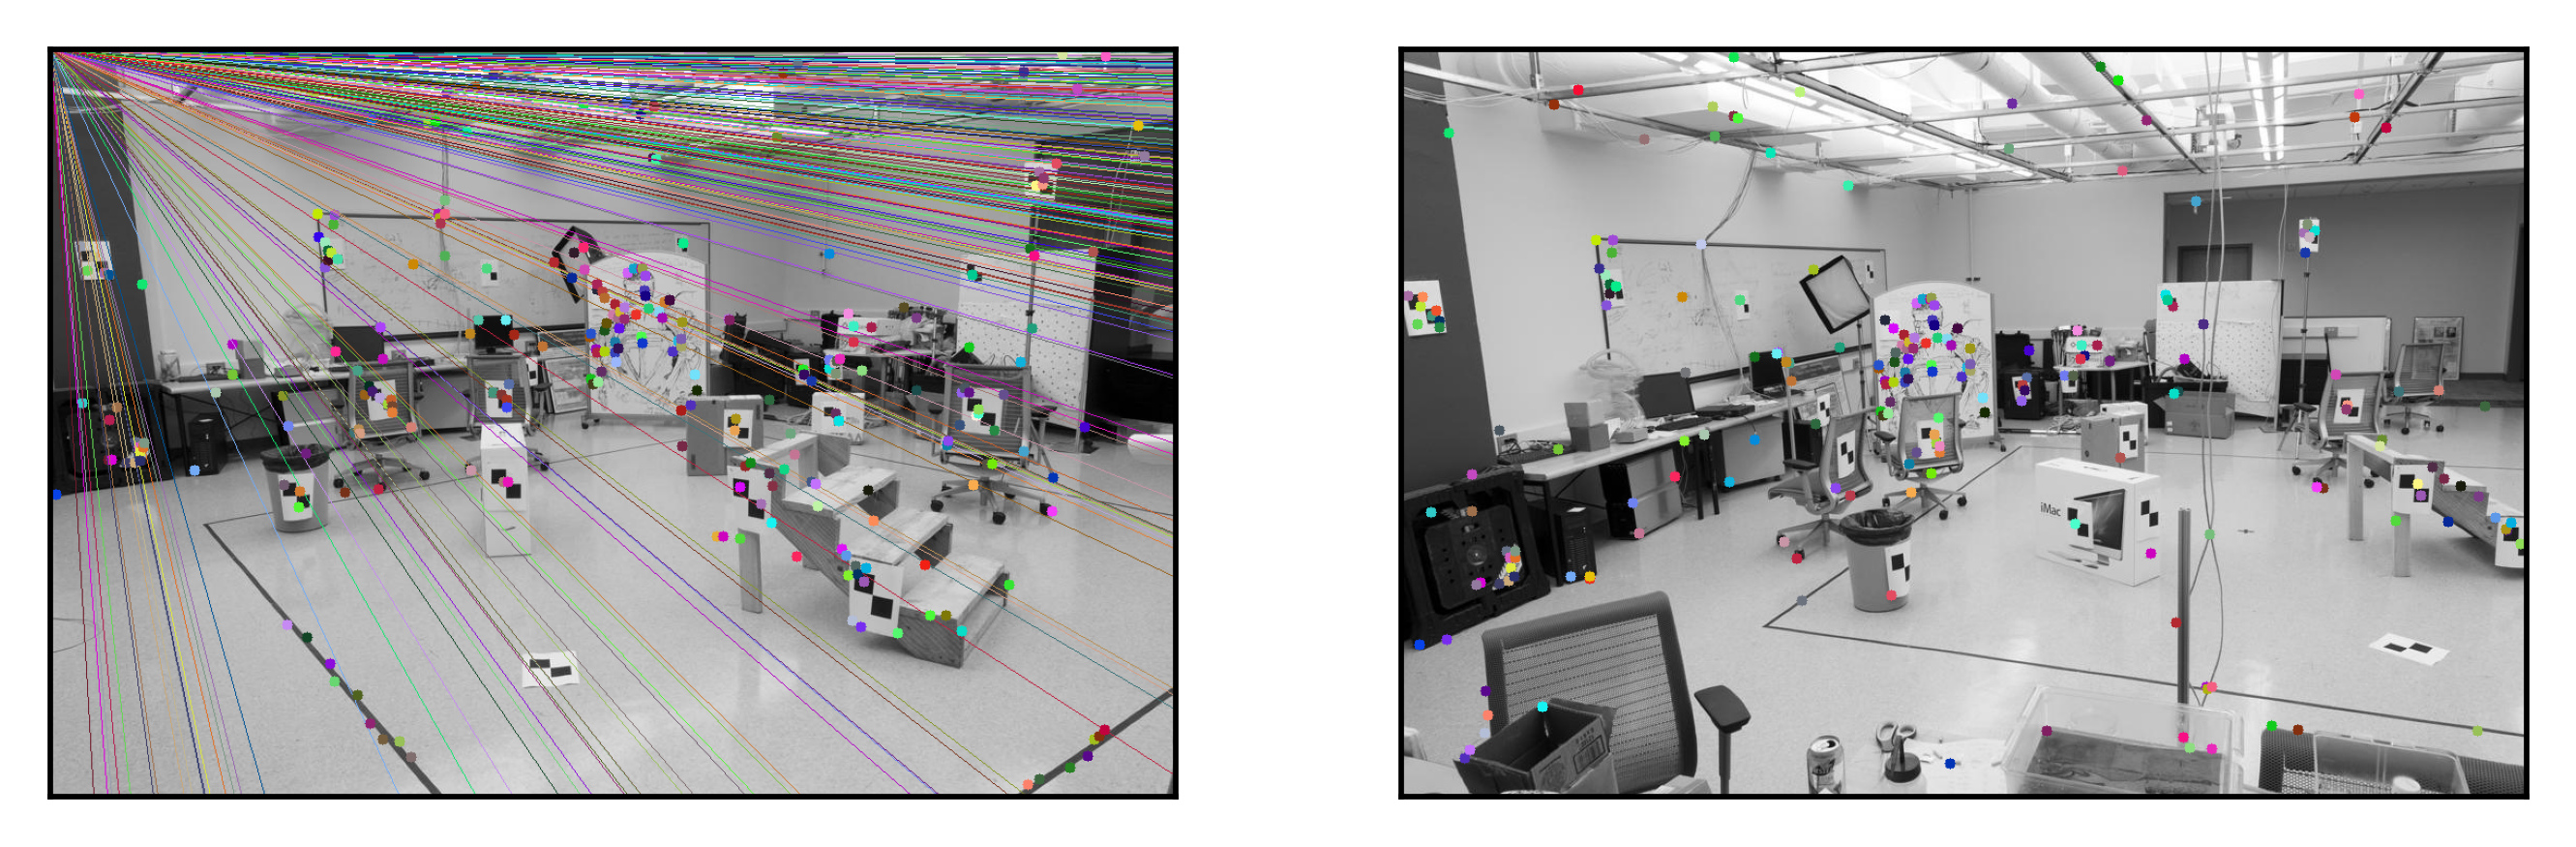

In [75]:
img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
lines1 = cv2.computeCorrespondEpilines(right_coords.reshape(-1,1,2), 2,F_norm)
lines1 = lines1.reshape(-1,3)
lines2 = cv2.computeCorrespondEpilines(left_coords.reshape(-1,1,2), 2,F_norm)
lines2 = lines2.reshape(-1,3)
img5,img6 = drawEpipolarLines(img1,img2,lines1,left_coords.astype(int),right_coords.astype(int))
img5,img6 = drawEpipolarLines(img1,img2,lines2,left_coords.astype(int),right_coords.astype(int))
cv2.imwrite('Res1.jpg', img5)
cv2.imwrite('Res2.jpg', img6)

fig, ax=plt.subplots(1,2,dpi=516)
plt.subplot(121),plt.imshow(img5),plt.xticks([]),plt.yticks([])
plt.subplot(122),plt.imshow(img6),plt.xticks([]),plt.yticks([])
plt.show()